In [1]:
library(tidyverse)
library(cowplot)
library(ggsci)
library(RColorBrewer)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Microbiome figure: Taxa barcharts for baby 108

## Read in data

In [2]:
stool_data = read_csv('../data/metadata/stool/stool_metadata.csv') %>%
                 left_join(read_csv('../data/metadata/stool/stool_abx_usage.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/metadata/stool/stool_titers_yr1.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/stool/kraken_alpha_diversity.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/stool/ko_alpha_diversity.csv'), by = 'SampleID')
stool_kraken_nmds = read_csv('../data/stool/kraken_nmds_babies.csv') %>% rename_with( ~ paste0("Kraken_", .x), -SampleID)
stool_ko_nmds = read_csv('../data/stool/ko_nmds_babies.csv') %>% rename_with( ~ paste0("KO_", .x), -SampleID)
stool_data = stool_data %>% left_join(stool_kraken_nmds, by = 'SampleID') %>% left_join(stool_ko_nmds, by = 'SampleID')
stool_data = stool_data %>% mutate(VR_group = ifelse(is.na(VR_group), 'Not Measured', VR_group))
stool_data = stool_data %>% filter(gt_2.5 == TRUE)
stool_data %>% head

Rows: 709 Columns: 26
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): SampleID, SubmissionType, DiversigenCheckInSampleName, BoxLocatio...
dbl   (7): SampleNumber, BabyN, Plate, Row, Column, age_at_collection, Count
lgl   (6): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 709 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SampleID
dbl (2): days_since_abx_start, days_since_abx_end
lgl (3): never_abx, on_abx, previous_abx

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set 

SampleID,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,⋯,species_richness,ko_shannon,ko_evenness,ko_richness,Kraken_MDS1,Kraken_MDS2,Kraken_MDS3,KO_MDS1,KO_MDS2,KO_MDS3
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
204_V5,Primary in Tube,1,NA,204_S,"Box 7, A1",Stool,Human Infant,MetaG,204,⋯,262,9.631071,0.06754679,3552,0.04696486,-0.6813761,-0.1710681,0.361944587,-0.2445720,0.13084552
226_V1,Primary in Tube,2,NA,NA,"Box 7, A2",Stool,Human Infant,MetaG,226,⋯,143,11.065302,0.45952748,3481,-1.68264332,-0.2294583,-0.1636196,-0.808974891,-0.1701531,0.05333913
107_V3,Primary in Tube,3,NA,NA,"Box 7, A3",Stool,Human Infant,MetaG,107,⋯,267,10.381667,0.20224759,3664,-0.27366582,-0.8886653,-0.3349565,0.004286036,-0.2128138,-0.38590665
108_V3,Primary in Tube,4,NA,NA,"Box 7, A4",Stool,Human Infant,MetaG,108,⋯,581,10.545280,0.26200950,3485,-0.33309773,0.7469011,0.4898332,-0.054777557,0.5141869,-0.06048777
109_V1,Primary in Tube,5,NA,NA,"Box 7, A5",Stool,Human Infant,MetaG,109,⋯,193,9.624191,0.11626061,2458,-0.80339905,-0.6660686,-0.5369415,0.367008649,-0.2352781,0.17121560
108_V2,Primary in Tube,6,NA,NA,"Box 7, A6",Stool,Human Infant,MetaG,108,⋯,178,9.220455,0.10696066,2822,-0.99773114,1.0968788,0.3873633,0.193437912,0.7153323,0.55921270


In [3]:
nasal_data = read_csv('../data/metadata/nasal/nasal_metadata.csv')
nasal_data = nasal_data %>% add_column('age_at_collection' = as.double(difftime(nasal_data$CollectionDate, nasal_data$DOB, units='days'))) %>%
                 left_join(read_csv('../data/metadata/nasal/nasal_abx_usage.csv'), by='SampleID') %>%
                 left_join(read_csv('../data/metadata/nasal/nasal_titers_yr1.csv'), by='SampleID') %>%
                 left_join(read_csv('../data/nasal/otu_alpha_diversity.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/nasal/otu_nmds_babies.csv'))
head(nasal_data)

Rows: 1008 Columns: 23
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): SubmissionType, SampleID, DiversigenCheckInSampleName, ReplacesLo...
dbl   (6): SampleNumber, SequencingType, BabyN, Plate, Row, Column
lgl   (5): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1008 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SampleID
dbl (2): days_since_abx_start, days_since_abx_end
lgl (3): never_abx, on_abx, previous_abx

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_co

SubmissionType,SampleNumber,SampleID,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,⋯,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2,shannon_div,simpson_e_div,n_otus_div,MDS1,MDS2,MDS3
<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Primary in Tube,1,103_V5_NS_A1,NA,NA,NA,"Box 1, A1",Nasal Swab,Human Infant,16,⋯,NA,NA,NA,NA,1.72045185,0.07548099,38,0.03476964,0.2711453,-0.24546932
Primary in Tube,2,106_V5_NS_A1,NA,NA,NA,"Box 1, A3",Nasal Swab,Human Infant,16,⋯,0.3125,1.3750,1.1403884,NVR,1.25565101,0.07274257,22,-0.34349902,0.1522628,0.44060459
Primary in Tube,3,107_V2_NS_A1,NA,NA,NA,"Box 1, A4",Nasal Swab,Human Infant,16,⋯,1.1250,0.3750,1.7834178,NVR,NA,NA,NA,NA,NA,NA
Primary in Tube,4,107_V3_NS_A1,NA,107_V8_NS_A1,NA,"Box 1, A5",Nasal Swab,Human Infant,16,⋯,1.1250,0.3750,1.7834178,NVR,NA,NA,NA,NA,NA,NA
Primary in Tube,5,107_V5_NS_A1,NA,NA,NA,"Box 1, A8",Nasal Swab,Human Infant,16,⋯,1.1250,0.3750,1.7834178,NVR,1.69497733,0.16593460,17,-0.36385022,0.2648479,-0.07368183
Primary in Tube,6,108_V4_NS_A1,NA,NA,NA,"Box 1, A9",Nasal Swab,Human Infant,16,⋯,0.3125,0.1875,0.4494199,LVR,0.05357943,0.07763519,13,-0.50225697,0.3444246,-0.10050053


In [4]:
stool_abundance_data = read_tsv('../data/stool/kraken_taxa_level_abunds/kraken_order_abunds.tsv') %>%
                           rename('Raw_Order' = `...1`) %>%
                           pivot_longer(!Raw_Order, names_to = "Sample", values_to = "Abundance")
stool_abundance_data %>% head

New names:
• `` -> `...1`
Rows: 143 Columns: 737
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): ...1
dbl (736): 101_S1, 101_V3, 101_V5, 102_V1, 102_V3, 102_V5, 103_S1, 103_V10, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Raw_Order,Sample,Abundance
<chr>,<chr>,<dbl>
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_S1,0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_V3,0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_V5,0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V1,0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V3,0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V5,1


In [5]:
nasal_taxonomy = read_tsv('../data/nasal/otu_taxonomy.tsv') %>% rename(Raw_Taxonomy = Taxonomy) %>%
                     mutate(Taxonomy = str_replace_all(Raw_Taxonomy, '\\(\\d*\\);', ';')) # MTS: I don't understand why you need double backslashes
nasal_taxonomy %>% head

Rows: 9204 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): OTU, Taxonomy
dbl (1): Size

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


OTU,Size,Raw_Taxonomy,Taxonomy
<chr>,<dbl>,<chr>,<chr>
Otu0001,21009360,Bacteria(100);Proteobacteria(100);Gammaproteobacteria(100);Pseudomonadales(100);Moraxellaceae(100);Moraxella(100);,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Moraxella;
Otu0002,6758489,Bacteria(100);Firmicutes(100);Bacilli(100);Bacillales(100);Staphylococcaceae(100);Staphylococcus(100);,Bacteria;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;
Otu0003,4690364,Bacteria(100);Firmicutes(100);Bacilli(100);Lactobacillales(100);Streptococcaceae(100);Streptococcus(100);,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;
Otu0004,4257515,Bacteria(100);Actinobacteria(100);Actinobacteria(100);Actinomycetales(100);Corynebacteriaceae(100);Corynebacterium(100);,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Corynebacteriaceae;Corynebacterium;
Otu0005,4038236,Bacteria(100);Proteobacteria(100);Gammaproteobacteria(100);Pseudomonadales(100);Moraxellaceae(100);Moraxella(100);,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Moraxella;
Otu0006,4036658,Bacteria(100);Firmicutes(100);Bacilli(100);Lactobacillales(100);Carnobacteriaceae(100);Dolosigranulum(100);,Bacteria;Firmicutes;Bacilli;Lactobacillales;Carnobacteriaceae;Dolosigranulum;


In [6]:
nasal_abundance_data = as_tibble(read.delim('../data/nasal/otu_table.gt10_rar10K.tsv'), rownames = 'Sample') %>% 
                           pivot_longer(!Sample, names_to = "OTU", values_to = "Abundance")
nasal_abundance_data = nasal_abundance_data %>% left_join(select(nasal_taxonomy, c('OTU', 'Taxonomy')), by='OTU')
nasal_abundance_data %>% head

Sample,OTU,Abundance,Taxonomy
<chr>,<chr>,<int>,<chr>
101_S1_NS_A1,Otu0001,1,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Moraxella;
101_S1_NS_A1,Otu0002,5845,Bacteria;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;
101_S1_NS_A1,Otu0003,117,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;
101_S1_NS_A1,Otu0004,9,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Corynebacteriaceae;Corynebacterium;
101_S1_NS_A1,Otu0005,0,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Moraxella;
101_S1_NS_A1,Otu0006,2479,Bacteria;Firmicutes;Bacilli;Lactobacillales;Carnobacteriaceae;Dolosigranulum;


In [7]:
## Load abx details
# abx_details <- read_delim("../../data/metadata/processed_data_sheets/updated_abx_details.csv")
abx_details <- read_delim("../data/metadata/antibiotic_usage.tsv")
head(abx_details)

Rows: 244 Columns: 12
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (8): PrimaryKey, BabyN, Name, Reason, Start_Date, End_Date, Duration_(d...
dbl  (3): AntibioticN, AgeAtStart, AgeAtEnd
date (1): DateOfBirth

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PrimaryKey,BabyN,AntibioticN,Name,Reason,Start_Date,End_Date,Duration_(days),DateOfBirth,AgeAtStart,AgeAtEnd,Route
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>
Baby134_Antibiotic1,Baby134,1,piperacillin/ tazobactam,R/O sepsis,2018-11-26,2018-11-28,2,2018-11-22,4,6,IV
Baby134_Antibiotic2,Baby134,2,ampicillin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4,5,IV
Baby134_Antibiotic3,Baby134,3,gentamicin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4,5,IV
Baby134_Antibiotic4,Baby134,4,vancomycin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4,5,IV
Baby235_Antibiotic1,Baby235,1,unknown anitbiotic(s),"R/O sepsis, later confirmed neg.",2018-06-19,Not Documented,Unknown,2018-06-13,6,NA,NA
Baby245_Antibiotic1,Baby245,1,ampicillin,"respiratory issues, R/O sepsis at birth",2018-07-23,2018-07-26,3,2018-07-22,1,4,IV


## Making plots

It's all yours Cathy!

In [8]:
## Add age of collection
nasal_sample_ages <- nasal_data %>% distinct(SampleID, BabyN, VisitCode, on_abx, age_at_collection, days_since_abx_start, days_since_abx_end)

nasal_abundance_data <- nasal_abundance_data %>%
    left_join(nasal_sample_ages, by=c("Sample"="SampleID"))

## Split taxonomy on ";", grab 4th value
nasal_taxa_level <- 4
nasal_abundance_data <- nasal_abundance_data %>%
    rowwise() %>%
    mutate(Taxonomy = strsplit(Taxonomy, ";", fixed = T)[[1]][nasal_taxa_level]) %>%
    ungroup
head(nasal_abundance_data)

Sample,OTU,Abundance,Taxonomy,BabyN,VisitCode,age_at_collection,days_since_abx_start,days_since_abx_end,on_abx
<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
101_S1_NS_A1,Otu0001,1,Pseudomonadales,101,S1,44,NA,NA,FALSE
101_S1_NS_A1,Otu0002,5845,Bacillales,101,S1,44,NA,NA,FALSE
101_S1_NS_A1,Otu0003,117,Lactobacillales,101,S1,44,NA,NA,FALSE
101_S1_NS_A1,Otu0004,9,Actinomycetales,101,S1,44,NA,NA,FALSE
101_S1_NS_A1,Otu0005,0,Pseudomonadales,101,S1,44,NA,NA,FALSE
101_S1_NS_A1,Otu0006,2479,Lactobacillales,101,S1,44,NA,NA,FALSE


In [9]:
## Add kraken column: split taxonomy on "|", grab 4th value and remove "o__"
stool_taxa_level <- 4
stool_abundance_data <- stool_abundance_data %>%
    rowwise() %>%
    mutate(Taxonomy = strsplit(Raw_Order, "|", fixed=T)[[1]][stool_taxa_level]) %>%
    ungroup

## Remove "o__" from string
stool_abundance_data$Taxonomy <- gsub("o__", "", stool_abundance_data$Taxonomy)
## Add age of collection and whether or not baby was taking antibiotics
stool_sample_ages <- stool_data %>%
    distinct(SampleID, BabyN, on_abx, VisitCode, age_at_collection, days_since_abx_start, days_since_abx_end)

stool_abundance_data <- stool_abundance_data %>%
    left_join(stool_sample_ages, by=c("Sample"="SampleID"))


head(stool_abundance_data)

Raw_Order,Sample,Abundance,Taxonomy,BabyN,VisitCode,age_at_collection,days_since_abx_start,days_since_abx_end,on_abx
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_S1,0,Acidobacteriales,101,S1,44,NA,NA,FALSE
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_V3,0,Acidobacteriales,101,V3,23,NA,NA,FALSE
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_V5,0,Acidobacteriales,101,V5,61,NA,NA,FALSE
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V1,0,Acidobacteriales,102,V1,6,NA,NA,FALSE
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V3,0,Acidobacteriales,102,V3,15,NA,NA,FALSE
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V5,1,Acidobacteriales,102,V5,59,NA,NA,FALSE


In [10]:
summarize_low_to_other <- function(abunds, other_fraction=0.01) {
    ## Label taxa as "Other" if below fractional abundance in ALL samples
    abunds %>%
    group_by(Sample) %>%
    mutate(rel_abund = Abundance / sum(Abundance)) %>%
    ungroup %>%
    group_by(Taxonomy) %>%
    rowwise() %>%
    mutate(Taxonomy = ifelse( all(rel_abund < other_fraction), "Other", Taxonomy )) %>%
    ungroup %>%
    return
    }

In [11]:
## Calculate relative abundance for nasal and stool
nasal_rel_abunds <- summarize_low_to_other(nasal_abundance_data, 0.1)
head(nasal_rel_abunds)

stool_rel_abunds <- summarize_low_to_other(stool_abundance_data, 0.1)
head(stool_rel_abunds)

Sample,OTU,Abundance,Taxonomy,BabyN,VisitCode,age_at_collection,days_since_abx_start,days_since_abx_end,on_abx,rel_abund
<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
101_S1_NS_A1,Otu0001,1,Other,101,S1,44,NA,NA,FALSE,0.0001
101_S1_NS_A1,Otu0002,5845,Bacillales,101,S1,44,NA,NA,FALSE,0.5845
101_S1_NS_A1,Otu0003,117,Other,101,S1,44,NA,NA,FALSE,0.0117
101_S1_NS_A1,Otu0004,9,Other,101,S1,44,NA,NA,FALSE,0.0009
101_S1_NS_A1,Otu0005,0,Other,101,S1,44,NA,NA,FALSE,0.0000
101_S1_NS_A1,Otu0006,2479,Lactobacillales,101,S1,44,NA,NA,FALSE,0.2479


Raw_Order,Sample,Abundance,Taxonomy,BabyN,VisitCode,age_at_collection,days_since_abx_start,days_since_abx_end,on_abx,rel_abund
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_S1,0,Other,101,S1,44,NA,NA,FALSE,0.000000e+00
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_V3,0,Other,101,V3,23,NA,NA,FALSE,0.000000e+00
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,101_V5,0,Other,101,V5,61,NA,NA,FALSE,0.000000e+00
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V1,0,Other,102,V1,6,NA,NA,FALSE,0.000000e+00
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V3,0,Other,102,V3,15,NA,NA,FALSE,0.000000e+00
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales,102_V5,1,Other,102,V5,59,NA,NA,FALSE,4.576332e-07


In [12]:
## Fix Sample colunms and add nasal category
nasal <- nasal_rel_abunds %>%
    mutate(stool_or_nasal = "Nasal",
           Sample = gsub("_NS.*", "", Sample)
          ) %>%
    arrange(age_at_collection) %>%
    select(-OTU)

stool <- stool_rel_abunds %>%
    mutate(stool_or_nasal = "Stool") %>%
    select(-Raw_Order)

## Combined nasal and stool data frames
nasal_stool_combined <- bind_rows(nasal, stool)

## Choose one age_at_collection per sample (if multiple are present)
nasal_stool_combined <- nasal_stool_combined %>%
    group_by(stool_or_nasal, BabyN, age_at_collection) %>%
    slice_min(Sample) %>%
    ungroup

## Add visit category
nasal_stool_combined <- nasal_stool_combined %>%
    mutate(visit_category = case_when(
        grepl("F", VisitCode) ~ "Follow-up",
        grepl("S", VisitCode) ~ "Sick",
        grepl("A", VisitCode) ~ "AOM",
        grepl("V", VisitCode) ~ "Well",
        TRUE ~ NA_character_
    )
          )
           
head(nasal_stool_combined)


Sample,Abundance,Taxonomy,BabyN,VisitCode,age_at_collection,days_since_abx_start,days_since_abx_end,on_abx,rel_abund,stool_or_nasal,visit_category
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>
101_V3,0,Other,101,V3,23,NA,NA,FALSE,0.0000,Nasal,Well
101_V3,9876,Bacillales,101,V3,23,NA,NA,FALSE,0.9876,Nasal,Well
101_V3,0,Other,101,V3,23,NA,NA,FALSE,0.0000,Nasal,Well
101_V3,1,Other,101,V3,23,NA,NA,FALSE,0.0001,Nasal,Well
101_V3,0,Other,101,V3,23,NA,NA,FALSE,0.0000,Nasal,Well
101_V3,0,Other,101,V3,23,NA,NA,FALSE,0.0000,Nasal,Well


In [13]:
babyN <- 108
days_cutoff <- 5

taxa_df <- nasal_stool_combined %>% filter(BabyN == babyN)

updated_age <- taxa_df %>%
    distinct(Sample, stool_or_nasal, age_at_collection) %>%
    arrange(age_at_collection, stool_or_nasal) %>%
    mutate(age_diff = age_at_collection - lag(age_at_collection),
           Age = case_when(
               is.na(age_diff) ~ age_at_collection, ## The first entry of diff will always contain one NA value since there is no value before it
               Sample == lag(Sample) & stool_or_nasal == "Stool" & age_diff <= days_cutoff & lag(stool_or_nasal) == "Nasal" ~ lag(age_at_collection), ## Choose nasal age_at_collection (for Stool) if Sample is the same but stool and nasal ages are within age_cutoff of eachother
               TRUE ~ age_at_collection
               )
          ) %>%
    select(-age_diff)

## Update Age in combined_df
taxa_df <- left_join(taxa_df, updated_age)
head(taxa_df)

Joining, by = c("Sample", "age_at_collection", "stool_or_nasal")


Sample,Abundance,Taxonomy,BabyN,VisitCode,age_at_collection,days_since_abx_start,days_since_abx_end,on_abx,rel_abund,stool_or_nasal,visit_category,Age
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
108_V4,0,Other,108,V4,54,NA,NA,FALSE,0.0000,Nasal,Well,54
108_V4,9954,Bacillales,108,V4,54,NA,NA,FALSE,0.9954,Nasal,Well,54
108_V4,5,Other,108,V4,54,NA,NA,FALSE,0.0005,Nasal,Well,54
108_V4,23,Other,108,V4,54,NA,NA,FALSE,0.0023,Nasal,Well,54
108_V4,0,Other,108,V4,54,NA,NA,FALSE,0.0000,Nasal,Well,54
108_V4,0,Other,108,V4,54,NA,NA,FALSE,0.0000,Nasal,Well,54


In [14]:
## Order x-axis by time
timepoints <- taxa_df %>%
    distinct(Sample, Age) %>%
    arrange(Age)

taxa_df$Sample <- factor(taxa_df$Sample, levels=timepoints$Sample)

taxa_order <- stool_abundance_data %>%
    distinct(Raw_Order, Taxonomy) %>%
    arrange(Raw_Order) %>%
    pull(Taxonomy)

taxa_order <- taxa_order[taxa_order %in% unique(taxa_df$Taxonomy)]
taxa_order <- c(taxa_order, "Other")
taxa_df$Taxonomy <- factor(taxa_df$Taxonomy, levels=taxa_order)

## Create color palette for taxa barcharts

## Use this code if a lot of colors are needed (i.e. >20)
# num_taxa <- length( unique(nasal_stool_combined$Taxonomy) )
# qual_col_pals <- brewer.pal.info[brewer.pal.info$category == 'qual',]
# col_vector <- unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
# set.seed(100)
# col_vector <- sample(col_vector[1:num_taxa], num_taxa, replace = FALSE)

col_vector <- pal_d3("category20")(length(taxa_order)) ## Grab colors from "d3" color palette
col_vector[8] <- rgb(1, 1, 0) ## Change grey to yellow
col_vector[length(col_vector)] <- rgb(0.5, 0.5, 0.5) ## Assign grey to "Other"

taxa_barcharts <- ggplot(data=taxa_df, aes(x=factor(Age), y=rel_abund, fill=factor(Taxonomy))) +
    geom_col() +
    facet_wrap(~stool_or_nasal, ncol=1, scales = "free_y") +
    theme_classic() +
    labs(
        y = "Relative abundance",
        fill = "Taxonomy"
        ) +
    scale_x_discrete(breaks = timepoints$Age, labels = timepoints$Age) +
    scale_fill_manual(breaks = taxa_order, values = col_vector) +
    theme(legend.justification = 0,
          axis.line.x.bottom = element_blank(),
          axis.text.x.bottom = element_blank(),
          axis.ticks.x.bottom = element_blank(),
          axis.title.x.bottom = element_blank(),
          legend.background = element_rect(color="black"),
          legend.margin = margin(1, 1, 1, 1, "mm"),
          legend.box.margin = margin(0, 0, 0, 0.5, "cm")
         ) +
    guides(fill = guide_legend(ncol = 1))


In [15]:
abx_df <- taxa_df %>%
    distinct(BabyN, Age, on_abx, days_since_abx_start, days_since_abx_end, age_at_collection) %>%
    mutate(on_recent_abx = ifelse(days_since_abx_end <= 7 | on_abx, TRUE, FALSE)) %>%
    replace_na(list(on_recent_abx = FALSE))

abx_details_by_baby <- abx_details %>% filter(BabyN == paste0("Baby", babyN))


if ( nrow(abx_df) > 0 ) {
    ## Grab Route from abx_details
    abx_df <- abx_df %>%
        rowwise() %>%
        ## I need to do it this way, rather than using "on_recent_abx", because I am indexing abx_details data frame, not abx_df.
        mutate(Route = ifelse(
            any( between(age_at_collection-abx_details_by_baby$AgeAtStart, 1, 7) | between(age_at_collection-abx_details_by_baby$AgeAtEnd, 0, 7) ),
            abx_details_by_baby$Route[which(between(age_at_collection-abx_details_by_baby$AgeAtStart, 1, 7) | between(age_at_collection-abx_details_by_baby$AgeAtEnd, 0, 7))],
            NA
            )
              ) %>%
        replace_na(list(Route = "None")) %>% ## Needed to replace NA here rather than ifelse statement for some reason
        ungroup
    abx_df$Route <- factor(abx_df$Route, levels=unique(abx_df$Route))
    
    on_abx <- ggplot() + geom_point(data=abx_df, aes(x=factor(Age), y=1, fill=factor(Route)), shape=21, size=5) +
        theme_void() +
        scale_x_discrete(breaks = timepoints$Age, labels = timepoints$Age) +
        scale_fill_manual(breaks = c('IM', 'IV', 'oral', 'topical', 'None'),
                          labels = c('IM', 'IV', 'Oral', 'Topical', 'None'),
                          values = c("yellow", "blue", "red", "orange", "white")
                         ) +
        theme(legend.justification = 0,
              legend.background = element_rect(color = "black"), ## Add border around legend
              legend.margin = margin(1, 1, 1, 1, "mm"), ## Add spacing inside legend box
              legend.box.margin = margin(0, 0, 0, 0.5, "cm") ## Add padding between legend and plot    
             ) +
        guides(fill = guide_legend(title = "Antibiotics within 1 week",
                                   title.hjust = 0.5,
                                   title.position = "top",
                                   direction = "horizontal"
                                  )
               )
    
    } else on_abx <- NULL


In [16]:
## Add visit category bar
visits_df <- taxa_df %>%
    distinct(Age, visit_category)

visits <- ggplot() +
    geom_point(data=visits_df, aes(x=factor(Age), y=1, fill=visit_category), shape=21, size=5) +
    scale_x_discrete(breaks = timepoints$Age, labels = timepoints$Age) +
    scale_fill_manual(values = c("royalblue", "cyan", "lightpink", "darkgoldenrod")) +
    theme_classic() +
    theme(legend.justification = 0,
          axis.line.y.left = element_blank(),
          axis.text.y.left = element_blank(),
          axis.ticks.y.left = element_blank(),
          axis.title.y.left = element_blank(),
          legend.background = element_rect(color = "black"), ## Add border around legend
          legend.margin = margin(1, 1, 1, 1, "mm"), ## Add spacing inside legend box
          legend.box.margin = margin(0, 0, 0, 0.5, "cm") ## Add padding between legend and plot  
         ) +
    labs(x = "Age (Days)") +
    guides(fill = guide_legend(title = "Reason for visit",
                               title.hjust = 0,
                               title.position = "top",
                               ncol = 2,
                               direction = "horizontal"
                              )
           )

In [17]:
## Plot legends and plots separately

## Extract legends from each plot
l1 <- get_legend(taxa_barcharts)
l2 <- get_legend(on_abx)
l3 <- get_legend(visits)

## Remove legends from plots
p1 <- taxa_barcharts + theme(legend.position = "none")
p2 <- on_abx + theme(legend.position = "none")
p3 <- visits + theme(legend.position = "none")

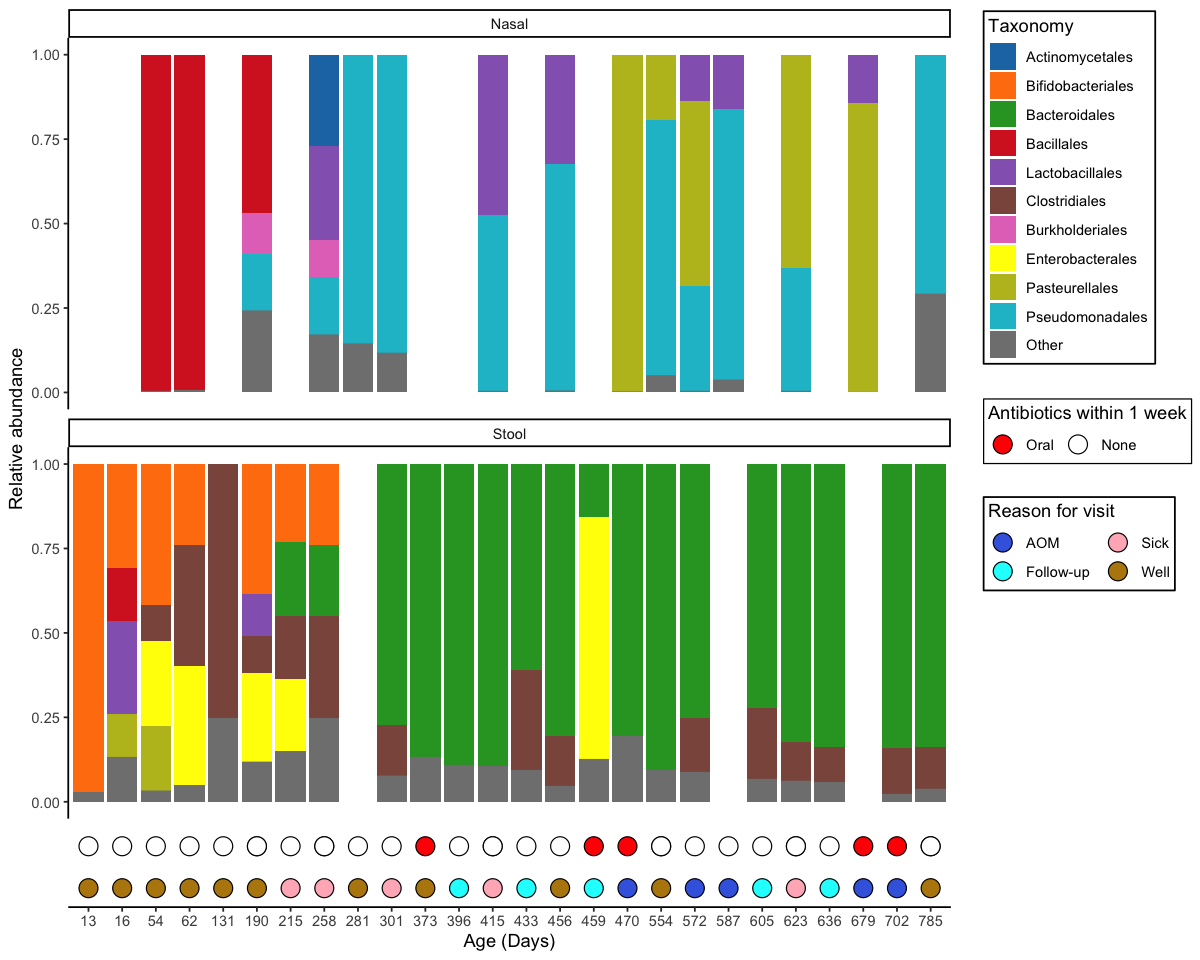

In [18]:
options(repr.plot.width=10, repr.plot.height=8)

## Arrange legends
legends <- plot_grid(l1, l2, l3, rel_heights = c(1, 0.30, 0.30), ncol=1)
right_plots <- plot_grid(legends, NULL, ncol = 1, rel_heights = c(1, 0.60)) ## NULL adds an empty plot at the bottom

## Arrange plots
left_plots <- plot_grid(p1, p2, p3, align = "v", ncol=1, axis="lr", rel_heights = c(1.5, 0.05, 0.18))

## Combine plots and legends
plot <- plot_grid(left_plots, right_plots, rel_widths = c(1, 0.25))
plot

In [19]:
## Save plot
ggsave("../figures/subject_108_microbiome_over_time.pdf", plot, height = 8, width = 10, dpi=700)